# RSAM notebook

In this tutorial, we will explore Real-time Seismic Amplitude Measurement (RSAM) data. 

RSAM is, by definition, computed on raw seismic data, so we can also think of it as "Raw" Seismic Amplitude Measurement, to distinguish from similar measurements we will make later on velocity and displacement seismograms.

## 1. Original RSAM system

The RSAM system was built around a 8-bit analog-to-digital-converter PC card: software was too slow in those days. Components of the original RSAM system were:

<font color='blue'>
<ol>
<li>Real-time bar graphs: showing average seismic amplitudes over last 2.56 s, 1 minute, and 10 minutes</li>
<li><b>1 minute and 10 minute mean signal amplitudes, logged to binary files. This is what most volcano-seismologists today think of as "RSAM data"!</b></li>
<li>"RSAM events": created by a simple STA/LTA detector running on each channel (NSLC)</li>
<li>Multi-station event (e.g. earthquake) and tremor alarm systems</li>
<li>Trends in RSAM data and other datasets (e.g. earthquake counts, tiltmeter data, gas flux, deformation, etc.) could be visualized with another software package called "BOB"</li>
</ol></font>

<table border=1><tr><td><img width=100% src="images/rsam.png" ></td><td>RSAM barcharts from Glowworm running in Montserrat in 2002. Tom Murray wrote the original RSAM system in 1985 and the GlowWorm system c. 1998 to provide volcano-monitoring extensions to Earthworm.</td></table></tr></table>

<table border=1><tr><td><img width=100% src="images/EndoMurray1991fig7.png" ></td><td>BOB plot. Fig 7 from Endo & Murray (1991). Top panel shows RSAM event rate at closest station to Pinatubo. Bottom 3 panels show RSAM data from stations at increasing distances. 30 days of data are show</td></table></tr></table>

In the figure above, 30 days of RSAM data are shown for three seismic stations. Loading and plotting 30 days of raw seismic data takes a while, but 1-minute RSAM data downsamples the raw seismic data by a factor of 6,000 (assuming a 100 Hz sampling rate), so long RSAM timeseries (hours, days, weeks, months, etc.) can be quickly loaded and plotted.

Reference:
- Endo, E.T., Murray, T. Real-time Seismic Amplitude Measurement (RSAM): a volcano monitoring and prediction tool. Bull Volcanol 53, 533–545 (1991).__[https://doi.org/10.1007/BF00298154](../../pdf/RSAM_EndoMurray1991.pdf)__

## 2. The RSAM class

We will exploit the RSAM class here (class in the Object-Oriented sense) which is in lib/SAM.py (a "Python module"). One of the methods of the RSAM class is to read the binary files written by the original RSAM system, as we will see.

More importantly, the RSAM class is a convenient way of downsampling (raw) seismic data. The original RSAM system used 2.56s, 60s, and 600s. I prefer to use 2.56s for events, and 60s for continuous data. For each time window, the RSAM class computes the following features:

- mean amplitude
- median amplitude
- max amplitude
- std (same as rms after detrending) amplitude
- mean amplitude in "VT band"
- mean amplitude in "LP band"
- mean amplitude in "VLP band"
- base-2 logarithm of the ratio of VT to LP band amplitudes (frequency ratio ...)

These are all features can be quickly computed because they can be done in the time domain. 

We can process the data in various ways. Some of these, e.g. using `select()`, `trim()`, `plot()`, should be familiar from ObsPy `Stream` objects. Others such as `downsample()` are not.

## 3. Frequency ratio
One of the metrics computed by the RSAM class is the "Frequency Ratio", which is a base-2 logarithm of the amplitude ratio of the VT frequency band versus the LP frequency band:

\begin{align}
fratio & = log_{2} \frac {A_{VT}}{A_{LP}} \\
\end{align}

                                                                        (Rodgers et al., 2016)

We use the following definitions of the VT and LP bands:

<table border=1>
    <tr><td>Class</td><td>Frequency Band (Hz)</td></tr>
    <tr><td>LP</td><td>0.8 - 4.0</td></tr>
    <tr><td>VT</td><td>4.0 - 18.0</td></tr>
</table>


## 4. Simple example

Here is a minimal example of computing RSAM data from an ObsPy Stream object. The data come from station REF at Redoubt Volcano in Alaska on 2009/03/22.

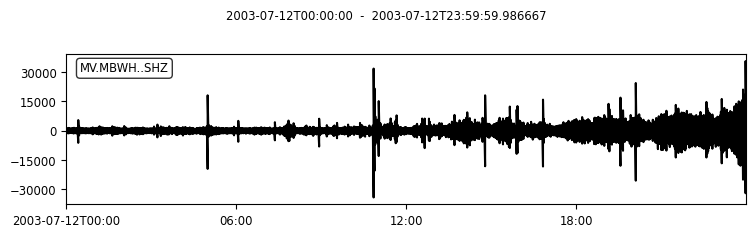

METRIC:  mean


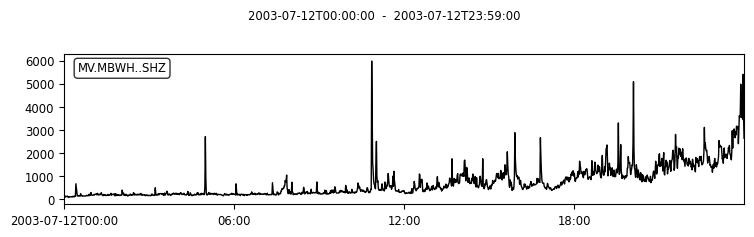

In [1]:
import sys
from pathlib import Path
import obspy
localLibPath = Path.cwd().resolve().joinpath('lib')
sys.path.append(str(localLibPath))
from SAM import RSAM
SDS_DIR = Path.cwd().joinpath('data','continuous','SDS')
SAM_DIR = Path.cwd().joinpath('data','continuous','SAM')

mseedfile = str(SDS_DIR.joinpath('2003','MV','MBWH','SHZ.D', 'MV.MBWH..SHZ.D.2003.193' ))
st = obspy.read(mseedfile)

# plot the raw Stream object
st.plot();

# compute and plot 1-minute RSAM
rsamObj = RSAM(stream=st, sampling_interval=60) # 60-s sampling interval
rsamObj.plot()

Let's see what helpful information we can get about the RSAM class:

In [ ]:
help(RSAM)

An RSAM object can be created by passing an ObsPy Stream object as an input parameter, and setting a sampling_interval (default: 60s). 

By default, the Stream object will be bandpass filtered from 0.5-18.0 Hz (the `filter` parameter) before computing RSAM. However, some other filters are defined for the VLP (0.02-0.2 Hz), LP (0.5-4.0 Hz), and VT (4.0-18.0 Hz) bands using `bands`, which is a Python dictionary. The frequency ratio is computed from the VT and LP bands, so override these definitions if they should be set differently for your dataset.

Internally, RSAM data for each ObsPy Trace object in the Stream is held in a pandas DataFrame.

In the present example, the Stream only contains 1 Trace and we can view the dataframe with:

In [ ]:
print(rsamObj.dataframes['MV.MBWH..SHZ'])

The 'time' column is in Unix epoch seconds (since 1970-01-01 00:00:00) (<em>I'll probably change this to Python datetime...</em>)

The original RSAM system calculated the mean signal amplitude at sample intervals of 2.56s, 60s, and 600s, as shown in the bar graph above. However, it is cheap and fast today to compute and store other metrics for each sample interval too, so RSAM objects also contain the min, max, median, and rms amplitude of each sample interval. (The aforementioned VLP, LP, and VT bands are computed just with the mean). A full list of the available metrics can be gotten like this:

In [ ]:
print(rsamObj.get_metrics())

Specific metrics can be plotted:

In [ ]:
rsamObj.plot(metrics=['mean','median','rms','max'])

For tremor analysis, I prefer to use the median, because it isn't biased by outliers the way the mean, rms, and max are. On the other hand, if my focus is to see the size of the largest events, it might be best to plot the max.

The way we have plotted the RSAM object so far calls the to_stream() method, so each RSAM DataFrame is converted into an ObsPy Trace before plotting. However, we can also plot the DataFrame directly with kind='line':

In [ ]:
rsamObj.plot(metrics=['median', 'max'], kind='line') 
# shorthand for metrics=['VLP', 'LP', 'VT', 'fratio']

Finally, we can plot the frequency band information:

In [ ]:
rsamObj.plot(metrics='bands', kind='line') 
rsamObj.plot(metrics='fratio', kind='line') 

## 5. Non-trivial example



In [ ]:
from obspy.clients.filesystem.sds import Client as sdsclient

# Compute RSAM in 1-day chunks for multiple network-station-location-channel's
mySDSclient = sdsclient(str(SDS_DIR))
startTime = obspy.core.UTCDateTime(2003,7,9)
endTime = obspy.core.UTCDateTime(2003,7,16)
secondsPerDay = 60 * 60 * 24
numDays = (endTime-startTime)/secondsPerDay
daytime = startTime
while daytime < endTime:
    print(f'Loading Stream data for {daytime}')
    st = mySDSclient.get_waveforms("MV", "*", "*", "[SBEHCD]*", daytime, daytime+secondsPerDay)
    print(f'- got {len(st)} Trace ids')
    print(f'Computing RSAM metrics for {daytime}, and saving to pickle files')
    rsamMV24h = RSAM(stream=st, sampling_interval=60)
    rsamMV24h.write(str(SAM_DIR), ext='csv', overwrite=True)
    daytime += secondsPerDay
del mySDSclient

In [2]:
# Read all the RSAM data back, and plot
#from importlib import reload
#reload(SAM)
#from SAM import RSAM
startTime = obspy.core.UTCDateTime(2003,7,9)
endTime = obspy.core.UTCDateTime(2003,7,16)
rsamObj = RSAM.read(startTime, endTime, SAM_DIR=str(SAM_DIR), ext='csv')
rsamObj = rsamObj.select(component='Z')
rsamObj.plot(metrics='median')

/Users/thompsong/Developer/skience2024/02 Volcano Monitoring/data/continuous/SAM/RSAM_*_2003_60s.csv
Reading  /Users/thompsong/Developer/skience2024/02 Volcano Monitoring/data/continuous/SAM/RSAM_MV.MBWH..SHZ_2003_60s.csv
Reading  /Users/thompsong/Developer/skience2024/02 Volcano Monitoring/data/continuous/SAM/RSAM_MV.MBLG..SHZ_2003_60s.csv
Reading  /Users/thompsong/Developer/skience2024/02 Volcano Monitoring/data/continuous/SAM/RSAM_MV.MBSS..SHZ_2003_60s.csv
Reading  /Users/thompsong/Developer/skience2024/02 Volcano Monitoring/data/continuous/SAM/RSAM_MV.MBRY..BHZ_2003_60s.csv
Reading  /Users/thompsong/Developer/skience2024/02 Volcano Monitoring/data/continuous/SAM/RSAM_MV.MBLY..BHZ_2003_60s.csv
Reading  /Users/thompsong/Developer/skience2024/02 Volcano Monitoring/data/continuous/SAM/RSAM_MV.MBRV..SHZ_2003_60s.csv
Reading  /Users/thompsong/Developer/skience2024/02 Volcano Monitoring/data/continuous/SAM/RSAM_MV.MBGH..BHZ_2003_60s.csv
Reading  /Users/thompsong/Developer/skience2024/02 V

Notice there is a significant data gap on July 13th. 

Finally, let's plot the Frequency Ratio - we do this just for station MBSS:

METRIC:  median


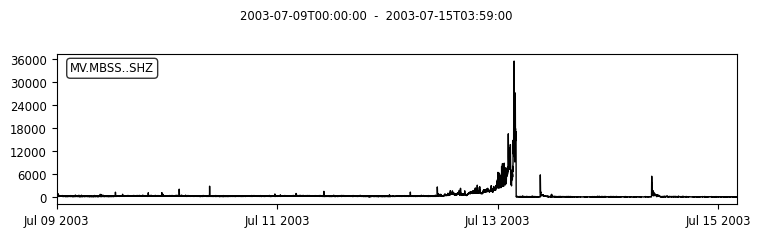

METRIC:  fratio


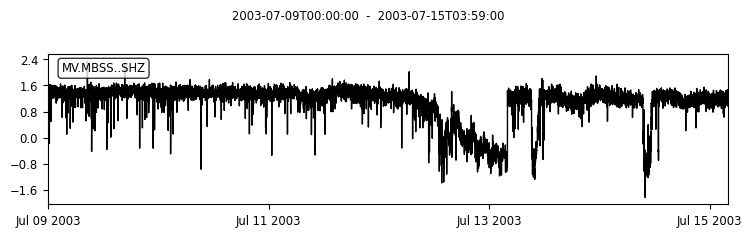

In [4]:
MBSSrsamObj = rsamObj.select(id='MV.MBSS..SHZ')
MBSSrsamObj.plot(metrics=['median','fratio'])

As you can see, there is quite an interesting decrease in the value of the Frequency Ratio as the RSAM intensifies late on July 12th through July 13th, then an hour or two before the main explosive event, the frequency ratio recovers. This is similar to what we saw at Whakaari:

<img width=100% src="images/whakaari_fratio_20191209.png" >

## 6. Legacy RSAM data 

### 6.1 Loading legacy RSAM data from binary files

The RSAM system was used at many observatories, and so many observatories likely have archives of RSAM binary files. But we can read these, making them Interoperable and Reusable. (Tiltmeter was saved in the same format, and so can also be read).

Next we will load 1 year of RSAM data for 8 stations recorded by the original RSAM system that was deployed in Montserrat. These data only have a 'mean' metric - it is just how they were recorded at the time.


In [ ]:
stime = obspy.core.UTCDateTime(1996,1,1,0,0,0)
etime = obspy.core.UTCDateTime(1996,12,31,23,59,59)
BINARY_DIR = SAM_DIR.joinpath('binary')
print(BINARY_DIR)
files = list(BINARY_DIR.glob(f'M???{stime.year}.DAT'))
print(files)
stations = [path.name[0:4] for path in files]
rsamObj = RSAM.readRSAMbinary(str(BINARY_DIR), stations, stime, etime)
#print(rsamObj)
rsamObj.plot()

### 6.2 Converting legacy RSAM binary files to modern RSAM CSV/Pickle files
Since we have already read the binary files into a (single) RSAM object, writing them to modern RSAM data format is as simple as:

In [ ]:
rsamObj.write(str(SAM_DIR), ext='csv')

## 7. RSAM data processing and analysis

### 7.1 read and plot

Next we will:
- (re-)read (from disk) the RSAM data from 1996/08/01 to 1996/08/05 for select SEED ids
- plot the data. By default, the plot() method will convert RSAM dataframes into an ObsPy Stream object, so it can be plotted in a familiar way.

In [ ]:
startt = obspy.core.UTCDateTime(1996,8,2)
endt = obspy.core.UTCDateTime(1996,8,6)
rsamObj = RSAM.read(startt, endt, SAM_DIR=str(SAM_DIR), ext='csv')
rsamObj.plot()   

### 7.2 Downsample 

In [ ]:
# downsample
rsamObj2 = rsamObj.downsample(new_sampling_interval=600) 

# plot
rsamObj2.plot()

These are remarkable cycles in RSAM. They appear to be about 4-6 hours apart. This is a phenomenon called "banded tremor". During these tremor bands, visual observations indicated that the lava dome was extruding at particularly high rates (up to 20m^3 was one estimate I heard), and at the peak of each cycle there was often ash venting. I proposed that the tremor bands were indicated of pressure cycles within the conduit - but caused by what? 
One suggestion is that the magma rises up the conduit in a stick-slip fashion. Basically, it gets stuck for a while, as the pressure builds below, and then shear fractures, allowing magma to suddenly extrude very quickly. 

Can we use some ObsPy STA/LTA detection tools to detect these tremor bands, in the same way we normally detect much shorter transient events, but just with longer STA/LTA settings? Let us try first on a single NSLC. This is based on examples at https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html, except we use longer STA and LTA time windows (15 and 100 minutes respectively), and we add a despiking step which attempts to remove transient events lasting a minute or less from the data before running the STA/LTA:


### 7.3 Tremor band detection with ObsPy trigger methods

#### 7.3.1 Single channel detection

In [ ]:
from obspy.signal.trigger import plot_trigger, classic_sta_lta, recursive_sta_lta

st2 = rsamObj2.to_stream()

sta_minutes = 15
lta_minutes = 100
threshON = 0.8
threshOFF = 0.5

for tr in st2:
    print(tr)
    sampling_interval_minutes = tr.stats.delta/60
    cft = recursive_sta_lta(tr.data, int(sta_minutes / sampling_interval_minutes), int(lta_minutes / sampling_interval_minutes))

    plot_trigger(tr, cft, threshON, threshOFF)

That seems to work quite well. Now let us try an event detector that uses several NSLC at once.

#### 7.3.2 Multi-channel detection

In [ ]:
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint
import numpy as np

threshStations = 3
triggerMethod = 'recstalta'
maxTriggerSecs = 2*lta_minutes*60

trig = coincidence_trigger(triggerMethod, threshON, threshOFF, st2, threshStations, sta=sta_minutes*60, lta=lta_minutes*60, 
                           max_trigger_length=maxTriggerSecs, delete_long_trigger=True)

In [ ]:
import vsmTools
import importlib
importlib.reload(vsmTools)
bandedTremorCat = vsmTools.triggers2catalog(trig, triggerMethod, threshON, threshOFF, sta_minutes*60, lta_minutes*60, maxTriggerSecs)

In [ ]:
bandedTremorDF = bandedTremorCat.to_dataframe()
print(bandedTremorDF)

In [ ]:
import pandas as pd
bandedTremorCat.plot_eventrate(binsize=pd.Timedelta(days=1))

In [ ]:
bandedTremorDF.plot.scatter(x='datetime', y='duration', rot=90)